<a href="https://colab.research.google.com/github/rjarun8/Pytorch/blob/main/PyTorch_Training_your_first_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the necessary packages
'''
https://www.pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/
'''
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

In [2]:

class LeNet(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet, self).__init__()

		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=800, out_features=500)
		self.relu3 = ReLU()

		# initialize our softmax classifier
		self.fc2 = Linear(in_features=500, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)

	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)

		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)

		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)

		# return the output predictions
		return output

In [3]:
import matplotlib
matplotlib.use("Agg")
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time

In [4]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# load the KMNIST dataset
print("[INFO] loading the KMNIST dataset...")

trainData = KMNIST(root="data", train=True, download=True,
	transform=ToTensor())
testData = KMNIST(root="data", train=False, download=True,
	transform=ToTensor())


# calculate the train/validation split
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))


[INFO] loading the KMNIST dataset...



Extracting data/KMNIST/raw/train-images-idx3-ubyte.gz to data/KMNIST/raw




Extracting data/KMNIST/raw/train-labels-idx1-ubyte.gz to data/KMNIST/raw




Extracting data/KMNIST/raw/t10k-images-idx3-ubyte.gz to data/KMNIST/raw




Extracting data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to data/KMNIST/raw

[INFO] generating the train/validation split...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True,
	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [7]:
print("[INFO] initializing the LeNet model...")
model = LeNet(
	numChannels=1,
	classes=len(trainData.dataset.classes)).to(device)

[INFO] initializing the LeNet model...


In [8]:
# initialize our optimizer and loss functio

lossFn = nn.NLLLoss()
opt = Adam(model.parameters(),lr=INIT_LR)

# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

[INFO] training the network...


In [9]:
# loop over our epochs


print(model)
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
	# switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()

In [11]:
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avgValLoss, valCorrect))

[INFO] EPOCH: 10/10
Train loss: 0.010835, Train accuracy: 0.9962
Val loss: 0.081191, Val accuracy: 0.9821



In [12]:
# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()
	
	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

[INFO] total time taken to train the model: 94.75s
[INFO] evaluating network...
              precision    recall  f1-score   support

           o       0.98      0.94      0.96      1000
          ki       0.96      0.89      0.92      1000
          su       0.92      0.94      0.93      1000
         tsu       0.97      0.97      0.97      1000
          na       0.93      0.94      0.93      1000
          ha       0.96      0.94      0.95      1000
          ma       0.89      0.98      0.93      1000
          ya       0.98      0.96      0.97      1000
          re       0.93      0.98      0.95      1000
          wo       0.97      0.95      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [13]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot.png')
# serialize the model to disk
torch.save(model,'cnn_torch.pth')

In [14]:
# set the numpy seed for better reproducibility
import numpy as np
np.random.seed(42)
# import the necessary packages
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
import argparse
import imutils
import torch
import cv2

In [15]:
# set the device we will be using to test the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load the KMNIST dataset and randomly grab 10 data points
print("[INFO] loading the KMNIST test dataset...")
testData = KMNIST(root="data", train=False, download=True,
	transform=ToTensor())
idxs = np.random.choice(range(0, len(testData)), size=(10,))
testData = Subset(testData, idxs)
# initialize the test data loader
testDataLoader = DataLoader(testData, batch_size=1)
# load the model and set it to evaluation mode
model = torch.load(r'/content/cnn_torch.pth').to(device)
model.eval()

[INFO] loading the KMNIST test dataset...


LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

[INFO] ground truth label: ki, predicted label: ki


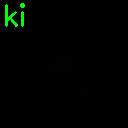

[INFO] ground truth label: ki, predicted label: ki


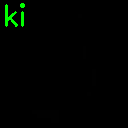

[INFO] ground truth label: ki, predicted label: ki


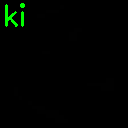

[INFO] ground truth label: ha, predicted label: ha


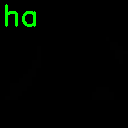

[INFO] ground truth label: tsu, predicted label: tsu


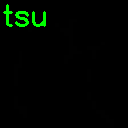

[INFO] ground truth label: ya, predicted label: ya


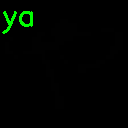

[INFO] ground truth label: tsu, predicted label: tsu


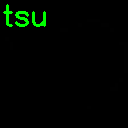

[INFO] ground truth label: na, predicted label: na


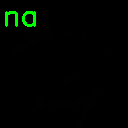

[INFO] ground truth label: ki, predicted label: ki


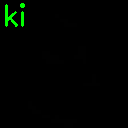

[INFO] ground truth label: tsu, predicted label: tsu


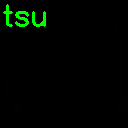

In [16]:
# switch off autograd

from google.colab.patches import cv2_imshow # to avoid colab crash
with torch.no_grad():
	# loop over the test set
	for (image, label) in testDataLoader:
		# grab the original image and ground truth label
		origImage = image.numpy().squeeze(axis=(0, 1))
		gtLabel = testData.dataset.classes[label.numpy()[0]]

		# send the input to the device and make predictions on it
		image = image.to(device)
		pred = model(image)

		# find the class label index with the largest corresponding
		# probability
		idx = pred.argmax(axis=1).cpu().numpy()[0]
		predLabel = testData.dataset.classes[idx]

		# convert the image from grayscale to RGB (so we can draw on
		# it) and resize it (so we can more easily see it on our
		# screen)
		origImage = np.dstack([origImage] * 3)
		origImage = imutils.resize(origImage, width=128)

		# draw the predicted class label on it
		color = (0, 255, 0) if gtLabel == predLabel else (0, 0, 255)
		cv2.putText(origImage, gtLabel, (2, 25),
			cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)

		# display the result in terminal and show the input image
		print("[INFO] ground truth label: {}, predicted label: {}".format(
			gtLabel, predLabel))
		cv2_imshow( origImage)
		cv2.waitKey(0)